# Mini-project_Advanced submission

# A. Problem formulation

This project centers on predicting food preferences from food images, exploring this interesting question:

## *'Does the appearance of the food affect the preference of the food*?'

By employing image classification techniques, it aims to uncover the relationship between visual appeal and our scale of preferernce towards certain foods. In other words, it's an investigation into the fascinating connection between visual stimuli and our food selection.

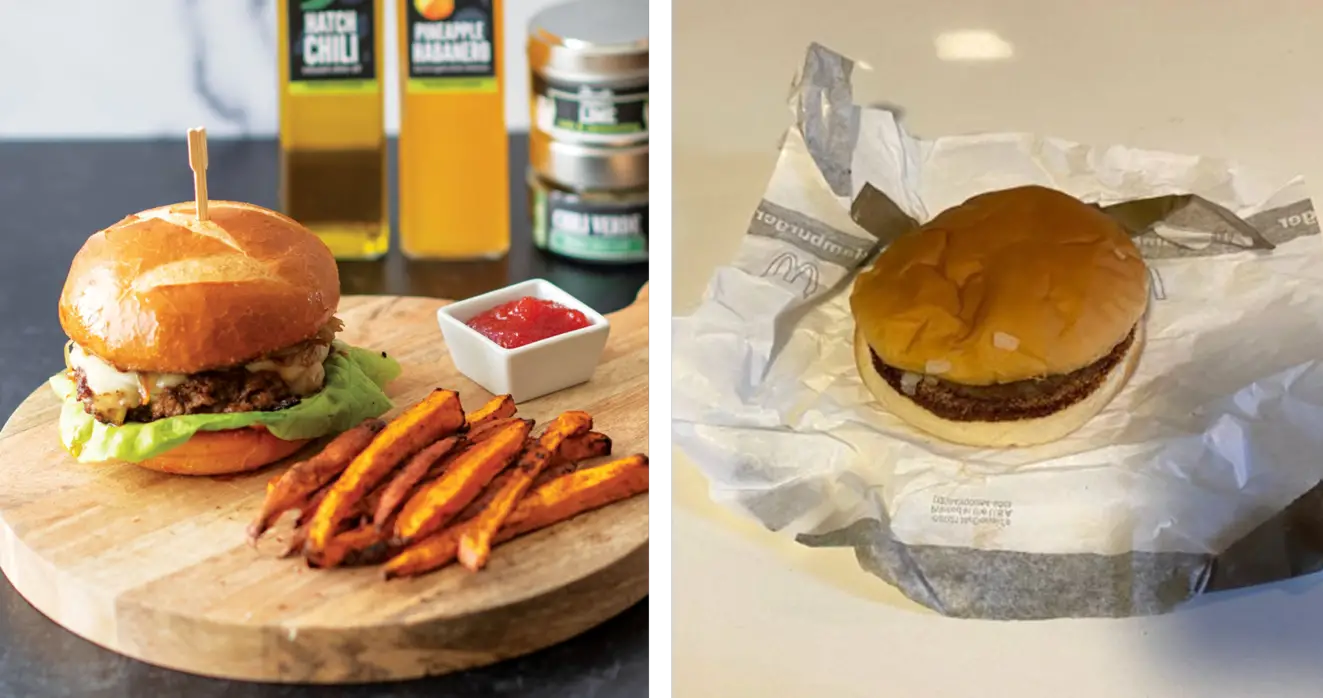

As you can see the two different burger images above,factors such as organized display, uniform color distribution, vibrant lighting, and the choice of a well-crafted plate significantly contribute to the visual allure of the dish which is highly relevant to the satistfaction on the food. Generally speaking, it's logical to assume that highly-rated restaurants excel in these aspects of plating, lighting, and overall food presentation.Let's dive into this question by experimenting on our Yummy Dataset!

# B. Machine Learning pipeline

Input of ML pipeline is small/large food images of MLEnd Yummy dataset. Input image will go through transformation stage including resizing, normalisation, data augmentation and feature extration throughout the CNN models. The final output of the CNN models will be 5 labels of 'How_much_did_you_like_it'/'Likeness' of each food.



In [ ]:
!pip install mlend > /dev/null
print('Installation completed')

Installation completed


Load the small Image dataset(99 images)

In [ ]:
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
import os

import mlend
from mlend import download_yummy_small, yummy_small_load

import os, sys, re, pickle, glob
import urllib.request
import zipfile

import IPython.display as ipd
from tqdm import tqdm
import librosa

drive.mount('/content/drive')
base_dir = '/content/drive/MyDrive/Data/MLEnd/yummy/' # set the directory path
MLYD_df = pd.read_csv(base_dir+'MLEndYD_image_attributes_small.csv')
MLYD_df[:5] #check the csv file

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,filename,Dish_name,Home_restaurant,Cuisine,Ingredients,Diet,Healthiness_rating,How_much_did_you_like_it,Rice_Chips,Benchmark_A
0,00001.jpg,steak_&_fries,resturaunt,american,"steak,fries,mixed_salad",non-veg,neutral,strongly_like,chips,Test
1,00002.jpg,beef_burger_meal,restaurant,american,"chips,burger,chicken_nugget",non-veg,unhealthy,like,chips,Train
2,00003.jpg,chicken_burger_with_fries_and_wings,restaurant,american,"fried_chicken_breast,lettuce,ketchup,sesame_se...",non-veg,unhealthy,like,chips,Train
3,00004.jpg,fried_rice_with_curd,home,indian,"rice,onion,potato,tomato,olive_oil,curd",vegetarian,neutral,like,rice,Train
4,00005.jpg,fish_and_chips,tcr_bar,british,"cod,beer,flour,tartare_sauce,peas,oil",vegetarian,neutral,strongly_like,chips,Test


Download Full Dataset (3,250 images)

In [ ]:
import mlend
from mlend import download_yummy, yummy_load

full_dir = base_dir + 'Full'
subset = {}
#Download the full dataset (If you don't have full image data, use the code below.)
# datadir = download_yummy(save_to = full_dir, subset = subset,verbose=1,overwrite=False)
# print('Full dataset saved successfully')

In [ ]:
MLYD_full_df = pd.read_csv(full_dir+'/yummy/MLEndYD_image_attributes_benchmark.csv')
print(MLYD_full_df.shape)
MLYD_full_df[:5]

(3250, 12)


,filename,Diet,Cuisine_org,Cuisine,Dish_name,Home_or_restaurant,Ingredients,Healthiness_rating,Healthiness_rating_int,Likeness,Likeness_int,Benchmark_A
0,000001.jpg,non_vegetarian,japanese,japanese,chicken_katsu_rice,marugame_udon,"rice,chicken_breast,spicy_curry_sauce",neutral,3.0,like,4.0,Train
1,000002.jpg,non_vegetarian,english,english,english_breakfast,home,"eggs,bacon,hash_brown,tomato,bread,tomato,bake...",unhealthy,2.0,like,4.0,Train
2,000003.jpg,non_vegetarian,chinese,chinese,spicy_chicken,jinli_flagship_branch,"chili,chicken,peanuts,sihuan_peppercorns,green...",neutral,3.0,strongly_like,5.0,Train
3,000004.jpg,vegetarian,indian,indian,gulab_jamun,home,"sugar,water,khoya,milk,salt,oil,cardamon,ghee",unhealthy,2.0,strongly_like,5.0,Train
4,000005.jpg,non_vegetarian,indian,indian,chicken_masala,home,"chicken,lemon,turmeric,garam_masala,coriander_...",healthy,4.0,strongly_like,5.0,Train


# C. Transformation stage

1) Resizing image data

I will transform the images to uniform image size for the computational efficiency and better traininig as I've done in the basics project.

However, in this case, I would use bigger image size that our model can capture the detailed feature of the food image and the settings around the food. (resized image : 256*256)



2) Data augmentation

I will apply basic transformations to the image dataset to add a variations to the dataset improving the robustness of the model.

I decided to define the MyDataset Class to customize the dataset and integrate pre-processing, transformation in a interpretable way.

In [ ]:
import torch
from sklearn.preprocessing import LabelEncoder
import torchvision.transforms as transforms

Simple data preprocessing - Replace NaN, Rename Columns

In [ ]:
#Small dataset
#Rename the target column
MLYD_df.rename(columns={'How_much_did_you_like_it': 'label'}, inplace=True)
img_dir = '/content/drive/MyDrive/Data/MLEnd/yummy/MLEndYD_images_small/'

#Fill the nan value to middle value 'neutral'
MLYD_df['label'].fillna('neutral', inplace=True)

In [ ]:
#Large dataset
MLYD_full_df.rename(columns={'Likeness': 'label'}, inplace=True)
img_full_dir = '/content/drive/MyDrive/Data/MLEnd/yummy/Full/yummy/MLEndYD_images'

#Fill the nan value to middle value 'neutral'
MLYD_full_df['label'].fillna('neutral', inplace=True)
MLYD_full_df.label.isnull().sum() #Check if there is NaN value

0

In [ ]:
# Decided to use 1700 images from the full image dataset for the computational efficiency
MLYD_full_df_1700 = MLYD_full_df[:1700]

In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.label_mapping = {'strongly_dislike': 0, 'dislike': 1, 'neutral': 2, 'like': 3, 'strongly_like': 4}
        self.class_names = list(self.label_mapping.keys())  # Store class names from the label mapping

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx, self.df.columns.get_loc('filename')]
        img = Image.open(img_dir+'/' + img_path) # You can change this to img_dir or img_full_dir depending on whether you'll be using small/large dataset

        if self.transform:
            image = self.transform(img)

        label = self.df.iloc[idx, self.df.columns.get_loc('label')]
        label = self.label_mapping.get(label)  # Map label using the custom mapping

        return image, label

# List of transformations
transform = transforms.Compose([
    transforms.Resize([256, 256]),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize pixel values with the mean and std of the RGB channels
])

# D. Modelling

Unlike the miniproject_basic, I will implement pre-trained CNN models and basic CNN model for the task.

CNN shows outstanding performance in learning high-level to low-level features of the image.Complex features such as edges, outline or pattern would be helpful for the image classification task for this project.CNN is also computationally effective for the image data since it significantly decrease the number of parameters through weight sharing. Pooling layers are also helpful reducing computational complexity while retaining crucial features.

Since we have limited amount of data for training, leveraging pre-trained models would be beneficial to capture the complicated features from the diverse image.

1. Chosen pre-trained models
- ResNet18
- ResNet50
- VGG16
- GoogleNet(Inception v1)

ResNet18 and ResNet50:

Both models are ResNet(Resuidual Network) with difference in its depth. Residual connection that skip connections between some layers allowed to deepen the layers while dealing with the vanishing gradient issue. I chose this model  because it is popular model for the excellent performance in image classification task balancing between model's complexity and computational efficiency.

VGG16:

VGG16 is known for its deep structure with small (3x3) convolutional filters and pooling layers. Deep structure of the model would help the models identify the complex patterns of our dataset and show good perfermance.

GoogleNet (Inception v1):

This model is the one that introduced the inception modules which use diverse filter size to capture feature of the image. This model is computationally efficient than other models reducing the number of parameters than other models.

| Model | Parameter | Top-5 Acc on ImageNet | Architecture |
|----------|----------|----------|----------|
| ResNet-50   | 25.6M  | 93.3%  |50 Conv with resuidual connection   |
| VGG-16   | 138M  | 92.7%  |16 Conv layer, 3 fully connected layers   |
| GoogleNet   | 6.8M  | 93.6%  |Inception modules |

2. Basic CNN model

I opted to apply a basic CNN model alongside pre-trained CNN models for two  reasons. Firstly, the deep layers of pre-trained models have the potential to cause overfitting in the model. Shallow layers of CNN might be more sutiable to capture the essential features of the image while achieving stable training. Secondly, I aim to draw a meaningful comparison between their performance disparities. Discovering reasons of poor/good performance between them.

In [ ]:
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

MLYD_df = MLYD_df[['filename', 'label']] #Since input is image path, clear rest of the unused features
MLYD_full_df_1000 = MLYD_full_df_1700[['filename', 'label']]

train_df, test_df = train_test_split(MLYD_df, test_size=0.2, random_state=42) #Change the first parameter to use small/large datset
train_dataset = MyDataset(df=train_df, transform=transform)
test_dataset = MyDataset(df=test_df, transform=transform)

# Dataloader to load data efficiently
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)

In [ ]:
dataloaders = {'train': train_loader,
               'test':test_loader}
dataset_sizes = {'train':len(train_dataset),
                 'test':len(test_dataset)}
class_names = train_dataset.class_names

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
import torchvision.models as models

#Function to visualise the predicted value and the truth value

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(10, 7))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                true_label = class_names[labels[j]]
                pred_label = class_names[preds[j]]
                ax.set_title(f'True: {true_label} | Predicted: {pred_label}')
                mean = [0.5, 0.5, 0.5]
                std = [0.5, 0.5, 0.5]

                # Denormalize the normalized image
                denormalized_inputs = inputs.cpu().data[j].permute(1, 2, 0) * torch.tensor(std) + torch.tensor(mean)
                ax.imshow(denormalized_inputs)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    plt.subplots_adjust(wspace=0.3, hspace=0.5)
                    plt.show()
                    return
        model.train(mode=was_training)

In [ ]:
#Class ofr training model
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    record = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': []
    }

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'test']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0

                # Load the data
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # Keep track of loss and corrects
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}') #Print the loss and acc of each epoch

                if phase == 'train':
                  record['train_loss'].append(epoch_loss)
                  record['train_acc'].append(epoch_acc)
                else:
                  record['test_loss'].append(epoch_loss)
                  record['test_acc'].append(epoch_acc)


                # deep copy the model
                if phase == 'test' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model, record

Function to effectively train multiple pre-trained models

In [ ]:
import torch
from torchvision import models
from torchvision.models import resnet50, ResNet50_Weights

def initialize_pretrained_model(model_name, num_classes):
    if model_name == 'vgg16':
        model = models.vgg16(weights='IMAGENET1K_V1')
        num_ftrs = model.classifier[6].in_features
        model.classifier[6] = torch.nn.Linear(num_ftrs, num_classes)
    elif model_name == 'googlenet':
        model = models.googlenet(weights='IMAGENET1K_V1')
        num_ftrs = model.fc.in_features
        model.fc = torch.nn.Linear(num_ftrs, num_classes)
    elif model_name == 'resnet50':
        model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        num_ftrs = model.fc.in_features
        model.fc = torch.nn.Linear(num_ftrs, num_classes)
    elif model_name == 'resnet18':
        model = models.resnet18(weights='IMAGENET1K_V1')
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 5)

    else:
        raise ValueError("Invalid model name.")

    model = model.to(device)
    return model

Model1. Train/Test Resnet 18

In [ ]:
pretrained_model = initialize_pretrained_model('resnet18', 5)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(pretrained_model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)
model1, record1 = train_model(pretrained_model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 48.5MB/s]


Epoch 0/9
----------
train Loss: 1.5290 Acc: 0.4304
test Loss: 1.5533 Acc: 0.3500
Epoch 1/9
----------
train Loss: 1.0904 Acc: 0.5190
test Loss: 1.6007 Acc: 0.4000
Epoch 2/9
----------
train Loss: 0.8291 Acc: 0.6962
test Loss: 1.7131 Acc: 0.4000
Epoch 3/9
----------
train Loss: 0.5300 Acc: 0.8608
test Loss: 1.7421 Acc: 0.3500
Epoch 4/9
----------
train Loss: 0.5453 Acc: 0.7848
test Loss: 1.8500 Acc: 0.4000
Epoch 5/9
----------
train Loss: 0.3431 Acc: 0.8987
test Loss: 1.9013 Acc: 0.4500
Epoch 6/9
----------
train Loss: 0.3367 Acc: 0.8987
test Loss: 1.8935 Acc: 0.3500
Epoch 7/9
----------
train Loss: 0.2865 Acc: 0.9494
test Loss: 1.9125 Acc: 0.4000
Epoch 8/9
----------
train Loss: 0.3065 Acc: 0.9494
test Loss: 1.7890 Acc: 0.4500
Epoch 9/9
----------
train Loss: 0.3755 Acc: 0.8608
test Loss: 1.8663 Acc: 0.4000
Training complete in 6m 30s
Best val Acc: 0.450000


Model2. Train/Test VGG16

In [ ]:
pretrained_model = initialize_pretrained_model('vgg16', 5)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(pretrained_model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)
model2, record2 = train_model(pretrained_model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 1.6495 Acc: 0.3165
test Loss: 1.4950 Acc: 0.3000
Epoch 1/9
----------
train Loss: 1.2033 Acc: 0.4810
test Loss: 1.3327 Acc: 0.5000
Epoch 2/9
----------
train Loss: 1.0482 Acc: 0.6076
test Loss: 1.3889 Acc: 0.4500
Epoch 3/9
----------
train Loss: 0.7573 Acc: 0.7089
test Loss: 1.7898 Acc: 0.2500
Epoch 4/9
----------
train Loss: 0.5202 Acc: 0.7975
test Loss: 2.3247 Acc: 0.3000
Epoch 5/9
----------
train Loss: 0.2016 Acc: 0.9367
test Loss: 2.2838 Acc: 0.3500
Epoch 6/9
----------
train Loss: 0.1366 Acc: 0.9747
test Loss: 2.3891 Acc: 0.4000
Epoch 7/9
----------
train Loss: 0.1235 Acc: 0.9747
test Loss: 2.4251 Acc: 0.3500
Epoch 8/9
----------
train Loss: 0.1068 Acc: 0.9747
test Loss: 2.6569 Acc: 0.4000
Epoch 9/9
----------
train Loss: 0.1019 Acc: 0.9620
test Loss: 2.8284 Acc: 0.4000
Training complete in 40m 54s
Best val Acc: 0.500000


Model3. Train/Test GoogleNet(InceptionV1)

In [ ]:
pretrained_model = initialize_pretrained_model('googlenet', 5)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(pretrained_model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)
model3, record3 = train_model(pretrained_model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 72.8MB/s]


Epoch 0/9
----------
train Loss: 1.4548 Acc: 0.3038
test Loss: 1.3639 Acc: 0.3500
Epoch 1/9
----------
train Loss: 1.2631 Acc: 0.4304
test Loss: 1.2918 Acc: 0.4500
Epoch 2/9
----------
train Loss: 1.0998 Acc: 0.5443
test Loss: 1.3590 Acc: 0.4000
Epoch 3/9
----------
train Loss: 1.0255 Acc: 0.5696
test Loss: 1.4044 Acc: 0.3500
Epoch 4/9
----------
train Loss: 0.9696 Acc: 0.6456
test Loss: 1.4765 Acc: 0.4000
Epoch 5/9
----------
train Loss: 0.8187 Acc: 0.6709
test Loss: 1.4271 Acc: 0.4500
Epoch 6/9
----------
train Loss: 0.8198 Acc: 0.6456
test Loss: 1.4026 Acc: 0.4000
Epoch 7/9
----------
train Loss: 0.7461 Acc: 0.8101
test Loss: 1.4456 Acc: 0.4000
Epoch 8/9
----------
train Loss: 0.8151 Acc: 0.7215
test Loss: 1.3821 Acc: 0.4000
Epoch 9/9
----------
train Loss: 0.8698 Acc: 0.6456
test Loss: 1.4086 Acc: 0.4500
Training complete in 6m 53s
Best val Acc: 0.450000


Model4. Train/Test Resnet50

In [ ]:
pretrained_model = initialize_pretrained_model('resnet50', 5)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(pretrained_model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)
model4, record4 = train_model(pretrained_model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 1.5051 Acc: 0.3418
test Loss: 1.3917 Acc: 0.4000
Epoch 1/9
----------
train Loss: 1.2586 Acc: 0.5063
test Loss: 1.3225 Acc: 0.3500
Epoch 2/9
----------
train Loss: 1.1735 Acc: 0.5063
test Loss: 1.3046 Acc: 0.4500
Epoch 3/9
----------
train Loss: 1.0658 Acc: 0.6076
test Loss: 1.3074 Acc: 0.5000
Epoch 4/9
----------
train Loss: 1.0058 Acc: 0.6076
test Loss: 1.3544 Acc: 0.4500
Epoch 5/9
----------
train Loss: 0.9267 Acc: 0.6709
test Loss: 1.3329 Acc: 0.4500
Epoch 6/9
----------
train Loss: 0.8824 Acc: 0.7089
test Loss: 1.3620 Acc: 0.4000
Epoch 7/9
----------
train Loss: 0.9108 Acc: 0.6582
test Loss: 1.3439 Acc: 0.4500
Epoch 8/9
----------
train Loss: 0.9367 Acc: 0.6456
test Loss: 1.3869 Acc: 0.4500
Epoch 9/9
----------
train Loss: 0.8970 Acc: 0.6835
test Loss: 1.3444 Acc: 0.4500
Training complete in 13m 26s
Best val Acc: 0.500000


Model5. Train/Test Basic CNN model

In [ ]:
import torch.nn as nn

class BasicCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(BasicCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(32 * 64 * 64, 128),  # Adjusted for input size of 256x256
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.classifier(x)
        return x

model = BasicCNN(num_classes=5)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)
model5, record5 = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 1.3831 Acc: 0.3038
test Loss: 1.2208 Acc: 0.4500
Epoch 1/9
----------
train Loss: 1.2982 Acc: 0.3544
test Loss: 1.2563 Acc: 0.4500
Epoch 2/9
----------
train Loss: 1.2264 Acc: 0.4684
test Loss: 1.2516 Acc: 0.4500
Epoch 3/9
----------
train Loss: 1.1082 Acc: 0.4557
test Loss: 1.3008 Acc: 0.4500
Epoch 4/9
----------
train Loss: 1.0610 Acc: 0.5696
test Loss: 1.3145 Acc: 0.4500
Epoch 5/9
----------
train Loss: 0.9731 Acc: 0.5696
test Loss: 1.3351 Acc: 0.4500
Epoch 6/9
----------
train Loss: 0.9415 Acc: 0.5696
test Loss: 1.3311 Acc: 0.4500
Epoch 7/9
----------
train Loss: 0.9158 Acc: 0.5949
test Loss: 1.3493 Acc: 0.4500
Epoch 8/9
----------
train Loss: 0.9280 Acc: 0.6329
test Loss: 1.3428 Acc: 0.4500
Epoch 9/9
----------
train Loss: 0.9051 Acc: 0.6329
test Loss: 1.3482 Acc: 0.4000
Training complete in 2m 13s
Best val Acc: 0.450000


# E. Methodology

- Train/Test Accuracy

I will monitor both train/test accuracy offers a comprehensive view of the model's performance. Train accuracy indicates how well the model understands the training patterns. On the other hand, test accuracy assesses the model's ability to generalize to unseen data, which is crucial for determining if the model has overfit to the training data. Comparing these accuracies will help to identify potential overfitting and generalisation issues.


- Train/Test Loss

I will keep track of train/test loss using CrossEntropy loss that quantify the error between predicted label and true label. Following the trend of train/test loss will also show the learning progress and the convergence of the model.

In [ ]:
def visualise_record(record):
    train_losses = record['train_loss']
    train_accuracies = record['train_acc']
    test_losses = record['test_loss']
    test_accuracies = record['test_acc']

    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b', label='Training loss')
    plt.plot(epochs, test_losses, 'r', label='Test loss')
    plt.title('Training and Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
    plt.plot(epochs, test_accuracies, 'r', label='Test accuracy')
    plt.title('Training and Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# F. Dataset


1) Data preprocessing with MyDataset Class (Section 4: Transformation Stage)

I designed MyDataset class at section4 to handle dataset preprocessing operation efficiently. I mapped categorical labels to numerical labels and implemented data augmentation technique to create diverse variations on the data for better robustness.

2) DataLoader for efficient training

I used dataloader for both training and testing to deliver data batches efficiently to the CNN model optimizing memory usage and processing time.

3) Implemented dataset - Small(99 images) and Large(1700 images)

I'll utilize both small and large image datasets to assess the model's performance variance and examine how dataset size impacts overfitting.

Dataset Overview

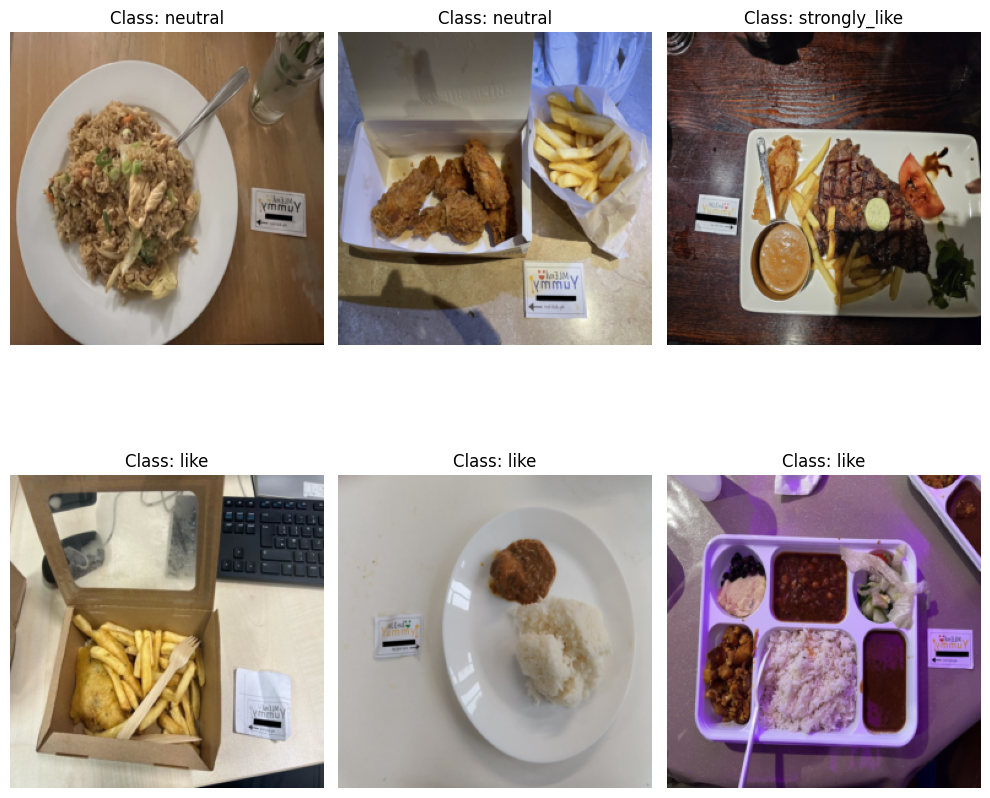

In [ ]:
# Check the visualised samples of the train_dataset after preprocessing
# {'strongly_dislike': 0, 'dislike': 1, 'neutral': 2, 'like': 3, 'strongly_like': 4}
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

plt.figure(figsize=(10, 10))
for i in range(6):
    image, label = train_dataset[i]
    class_name = train_dataset.class_names[label]
    denormalized_image = image.permute(1, 2, 0) * torch.tensor(std) + torch.tensor(mean)

    plt.subplot(2, 3, i + 1)
    plt.imshow(denormalized_image)
    plt.title(f'Class: {class_name}')
    plt.axis('off')
plt.tight_layout()
plt.show()


# 8 Results

- Experiment Results Summary

| Experiment | Dataset | Data Model | epoch | Scheduler | Top_Acc| Time |
|----------|----------|----------|----------|----------|----------|----------|
| A   | 99  | Resnet18  |10   | ExponentialLR  |0.450000  | 6m 30s|
| B   | 99  | ResNet50   |10   |ExponentialLR   |0.500000 |  13m 26s |
| C   | 99  | VGG16   |10   |ExponentialLR   |0.500000 | 40m 54s |
|D   |99  | GoggleNet  |10   |ExponentialLR   |0.450000|  6m 4s |
|E   | 99   | BasicCNN  |10   |ExponentialLR  |	0.450000 | 2m 13s|
|F   |1700   |Resnet18  |10   |ExponentialLR   |	0.468333 | 96m 2s |
|G   | 1700   | BasicCNN  |10   |ExponentialLR  |	0.432353 |43m 54s|
|H   | 1700   | GoogleNet  |10   |ExponentialLR  |	0.432353 |131m 51s|
|I   | 1700   | ResNet50  |10   |ExponentialLR  |0.444118 | 108m 45s|


I experimented on several different pre-trained CNN models and basic CNN model using 10 epoch and recorded its top test accuracy with processed time. Different size of image data is used from Experiment F.

Experiment using ResNet50 and VGG16 pre-trained model to 99 images of dataset showed the best test accuracy 0.5. However, overall the experimnet shows low accuracy.Considering time efficiency, basic CNN showed relatively good performance 0.45 with around 2minutes of processing time.

- Train/Test Accuracy & Loss Comparison

ResNet18- Model Performance


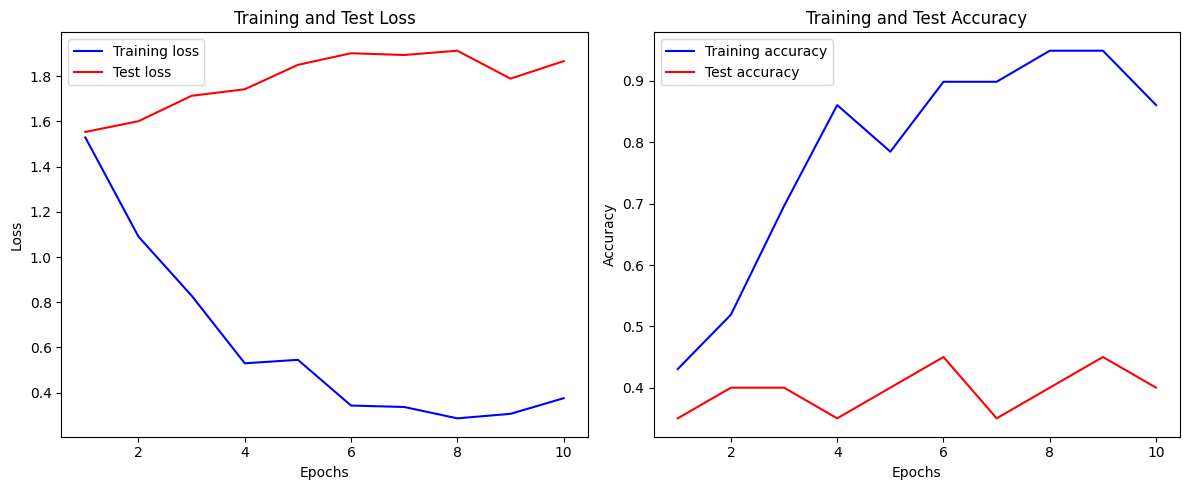

VGG16- Model Performance


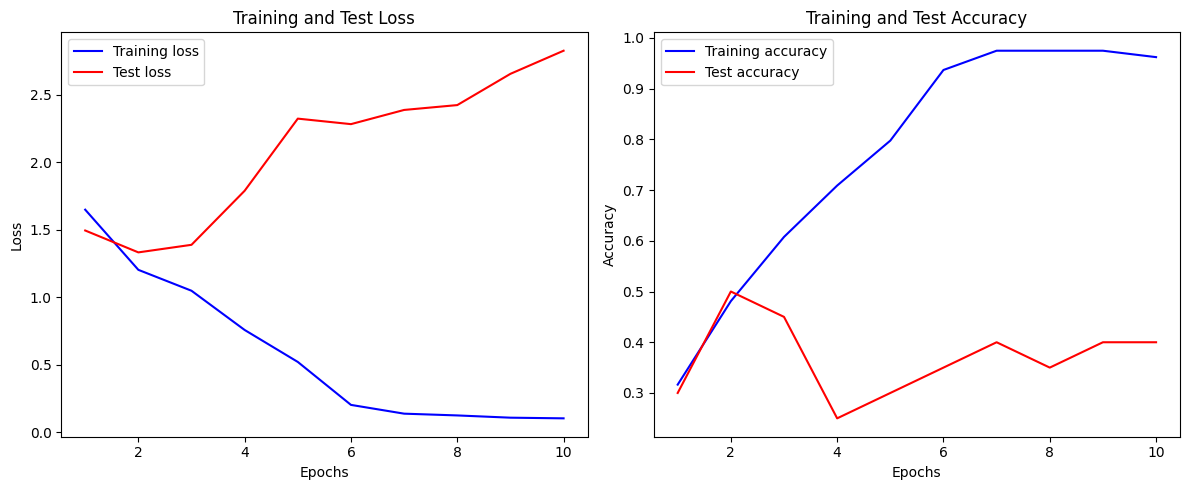

GoogleNet- Model Performance


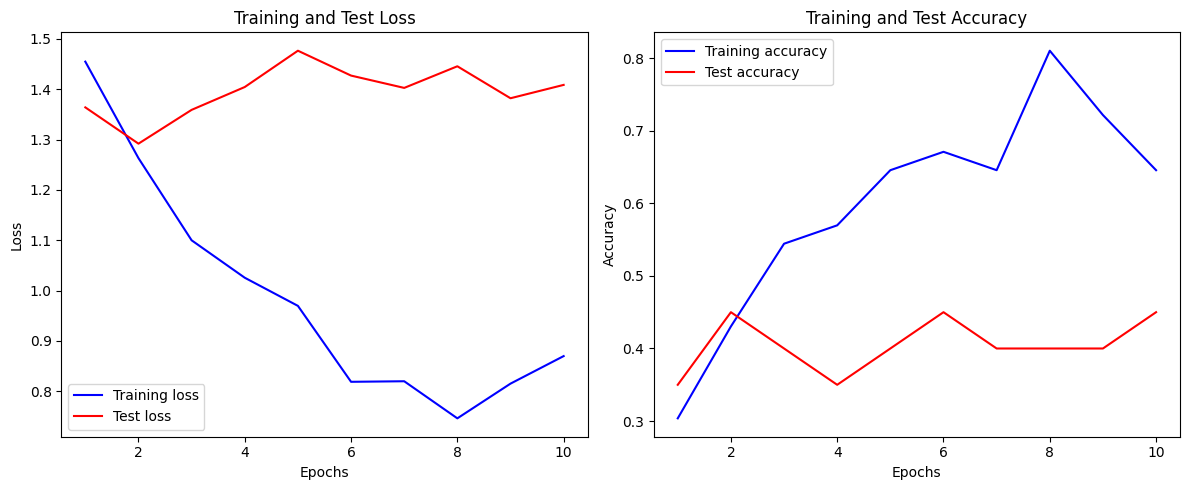

ResNet50- Model Performance


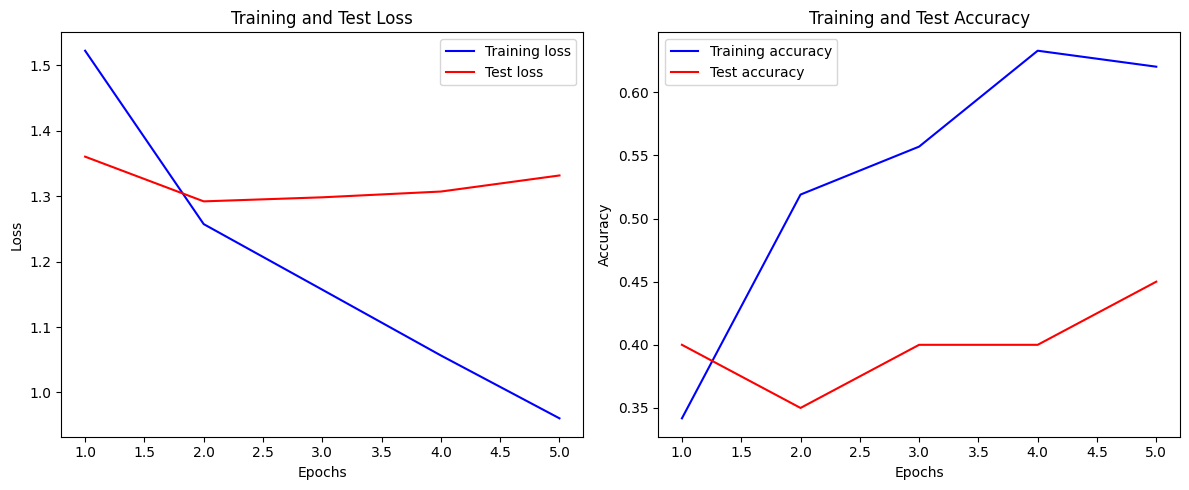

BasicCNN- Model Performance


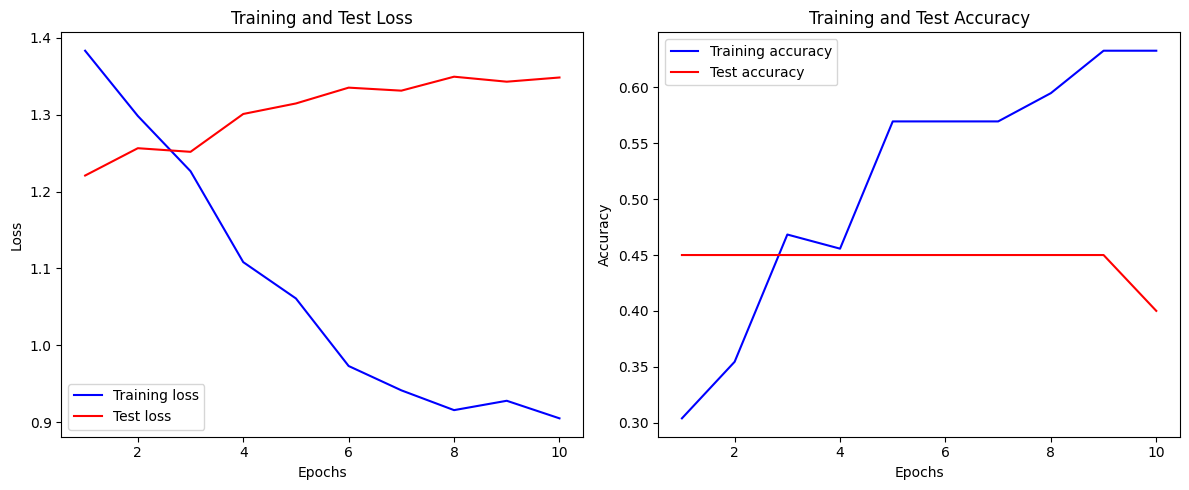

In [ ]:
records = [record1,record2,record3,record4,record5]
models = ['ResNet18','VGG16','GoogleNet','ResNet50','BasicCNN']
for rec,model_name in zip(records,models):
  print(model_name +'- Model Performance')
  visualise_record(rec)

The plotted graphs display an overfitting trend overall. The test loss is increasing, while the training loss is decreasing, indicating a widening gap between these two metrics. Additionally, the training accuracy and test accuracy exhibit an unstable, fluctuating trend, where the train accuracy steeply increases, while the test accuracy declines with the increasing number of epochs

- Predicted / True label Comparison -ExperimentB ResNet50

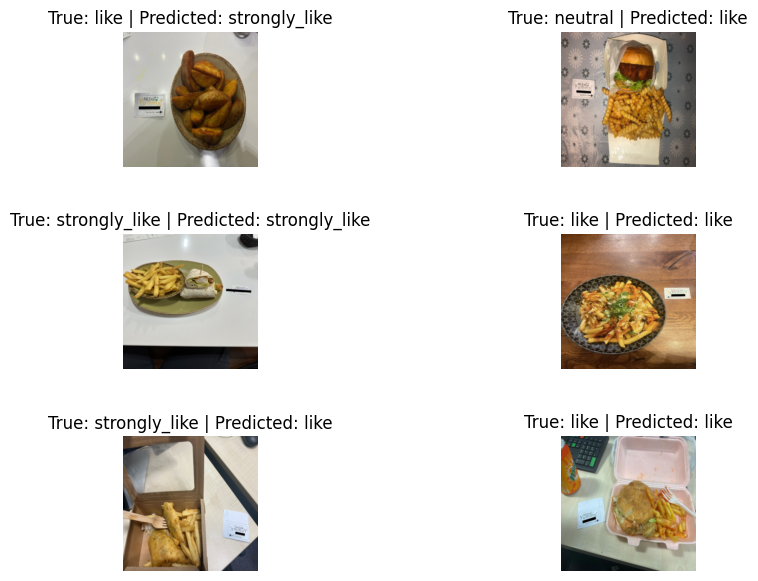

In [ ]:
visualize_model(model4)

This visualization provides a comparative analysis between the predicted and true labels utilizing the Experiment B ResNet50 model trained on a dataset containing 99 small images. While it's challenging to draw precise conclusions regarding the types of images the model favored, it offers insights into the model's decision-making process.

# G. Conclusions


My Conclusions


---

- Limitation on pre-trained models

The models employed in this project are ImageNet pre-trained, utilizing a diverse data to improve image classification capabilities. Nonetheless, the analysis reveals inherent limitations of pre-trained models. The disparity between the fine-tuning dataset's size and the expansive pre-trained dataset poses a risk of overfitting. In fact, overfitting is observed in the visualised plot: a divergence in training and testing performance, evident in the diminishing training loss alongside escalating test loss, coupled with poor test accuracy and superior train accuracy. Additionally, deep models like VGG16 demand extensive computational power, requiring about an hour for the 10 epoch training.

- Performance comparison between basic CNN model and pre-trained models

It's intriguing to note that the performance of a basic CNN, comprising 2 Convolutional layers and 2 linear layers, shows comparable results to those of pre-trained models. This suggests that the complex, deeper layers of the pre-trained models might not have significantly contributed to the performance in this specific classification task. It's possible that these intricate layers don't align with the nature of the task or were not match with the domain of the pre-trained dataset.

- Limitation on the dataset

The poor overall performance, especially with a test accuracy below 50%, could indeed be attributed to limitations within the dataset. In the context of the inquiry about whether food appearance influences food preference, the structure of the Yummy Dataset becomes a significant factor. The dataset, predominantly composed of food images collected by students, likely includes more home-taken images rather than those captured with an emphasis on visually appealing plating, unless taken specifically at restaurants.

This skew in the dataset composition could result in an imbalance between well-presented and poorly presented food images. Consequently, the model might struggle to discern meaningful patterns related to the preference scale (labels) due to this imbalance in the representation of visually appealing versus unappealing food compositions. This imbalance could pose a challenge for the model to effectively learn and generalize patterns associated with food preference based on appearance.


Suggestions on the Improvement


---

- Improvement of Data Quality and Size

As I have pointed out, Yummy Dataset lacks of representativeness for the good/poorly presented food images. Using a balanced representation of both well-displayed and poorly-displayed food images for training could indeed enhance the model's performance and provide valuable insights into what food presentations might influence customers' perceptions of taste.

However, my experiments revealed unexpected results despite increasing the dataset size from a smaller set of 99 images to a larger one of 1700 images. Surprisingly, the model's performance did not demonstrate substantial improvement. This observation suggests that simply enlarging the dataset might not suffice, especially for deep-layered pre-trained models.

Deep-layered pre-trained models might require even larger datasets to effectively capture the nuances of diverse food presentations without overfitting. Their intricate architectures demand more extensive and diverse data for robust learning and generalization. Despite the dataset expansion, these models may still struggle to effectively learn intricate patterns related to food presentation and taste preferences without a more comprehensive and varied dataset.

- Hyperparameter Tuning

Due to time constraints, I haven't had the chance to conduct detailed hyperparameter tuning on the CNN models. However, I plan to explore adjustments in the learning rate, batch size, and alternative optimizers like Adam, Adagrad, or RMSprop to potentially enhance convergence speed and computational efficiency. I aim to fine-tune dropout rates and integrate dropout layers to mitigate overfitting. Additionally, I will experiment with various schedulers, such as ReduceLROnPlateau or StepLR, to dynamically adjust the learning rate for improved stability in model convergence.